In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To do:

try small mu

for loop (convolve one basis at a time)

stop at every location (bandwidths, bubbles, smoothed basis, etc.) check after one iteration if the memory usage increase

In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

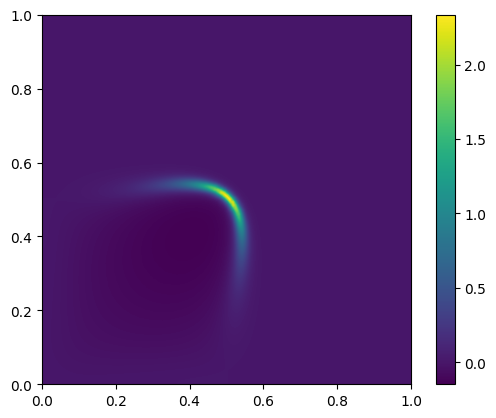

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [8]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

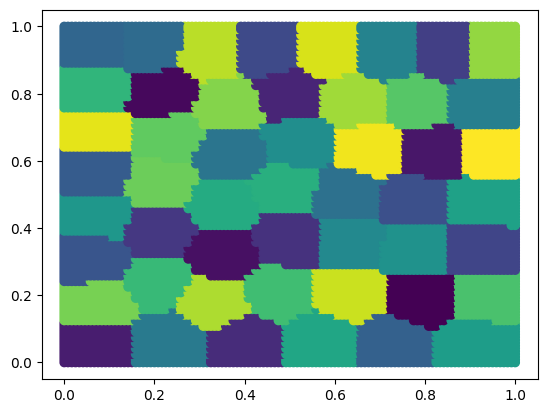

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

w: n x N

In [10]:
# # distance: N x mu
# # w: n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).expand(n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # n x N x mu
#     return window

In [11]:
# # x: n x N
# # neighbour_id: N x mu
# # w: n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     # n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id] * bubbles, dim=-1)

w: b x n x N

In [12]:
# # distance: N x mu
# # w: b x n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[1]
#     b = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).unsqueeze(0).expand(b, n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # b x n x N x mu
#     return window

In [13]:
# # x(decoder): n x N
# # neighbour_id: N x mu
# # w: b x n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     b = w.shape[0]
#     # b x n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id].unsqueeze(0).expand(b,-1,-1,-1) * bubbles, dim=-1)


In [14]:
N = datas.shape[1] // 2
n = 20
# fixed support (length)
mu = int(np.ceil(N/100))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [15]:
batch_size = 20
datas = datas.to(device)
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [16]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [17]:
# ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [18]:
n * batch_size * N * 8 / 1e9

0.0468512

In [19]:
# torch.autograd.set_detect_anomaly(True)
ed.train(train_data_loader=train_data, epochs=1000)

  0%|          | 0/50 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 330.00 MiB (GPU 0; 15.75 GiB total capacity; 14.79 GiB already allocated; 323.81 MiB free; 15.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [ ]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

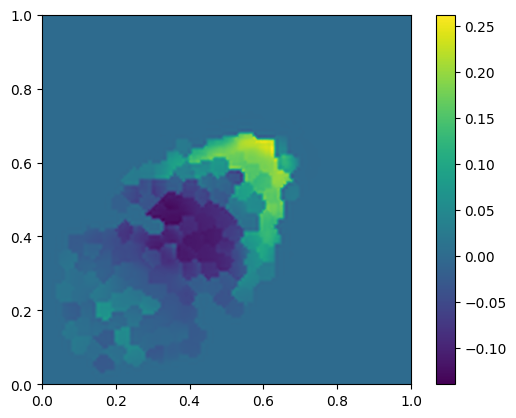

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
datas[999:1001, N:]

tensor([[2.5000e-03, 2.4000e-03, 2.2500e-03,  ..., 4.8000e-30, 4.8000e-30,
         6.9900e-30]])

In [ ]:
approximates[0]

tensor([ 0.0046,  0.0033,  0.0027,  ..., -0.0005, -0.0007, -0.0009],
       device='cuda:0', grad_fn=<SelectBackward0>)

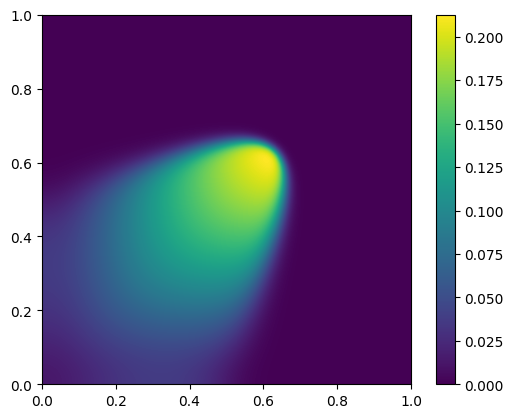

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, :N].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

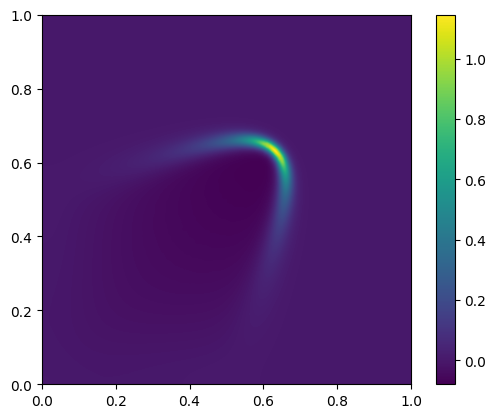

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

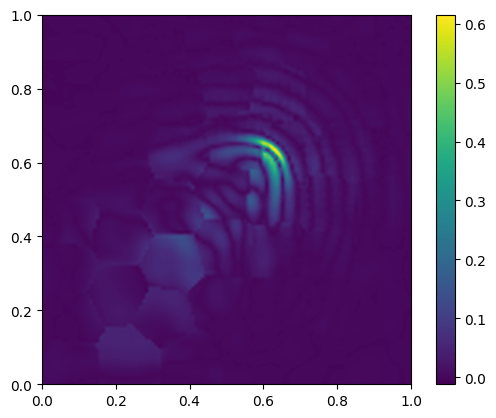

In [ ]:
err = abs(datas[999] - approximates[0])

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
encoded = ed.nrbs.encode(datas[999].to(device))

In [ ]:
encoded.shape

torch.Size([20])

In [ ]:
bandwidths = torch.bmm(
            encoded.repeat(n, 1, 1), ed.nrbs.bandwidth_layers
        ).permute(1, 0, 2)
bandwidths = bandwidths.detach().cpu()
bandwidths = torch.sigmoid(bandwidths)

TypeError: bmm(): argument 'mat2' (position 2) must be Tensor, not Linear

In [ ]:
basis_id = 0
bandwidths_loc = torch.zeros((N,))
for i in range(m):
    bandwidths_loc[np.where(clustering.labels_ == i)[0]] = bandwidths[:,basis_id,:][0][i]

In [ ]:
bandwidths[:,basis_id,:][0][i]

tensor(0.4977)

In [ ]:
bandwidths_loc.shape

torch.Size([14641])

In [ ]:
clustering.labels_.shape

(14641,)

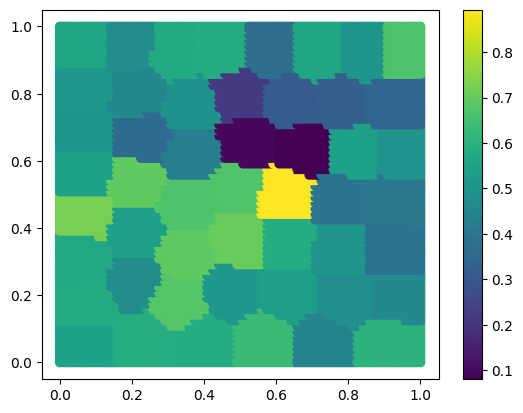

In [ ]:
plt.scatter(coords_x, coords_y,c=bandwidths_loc)
plt.colorbar()

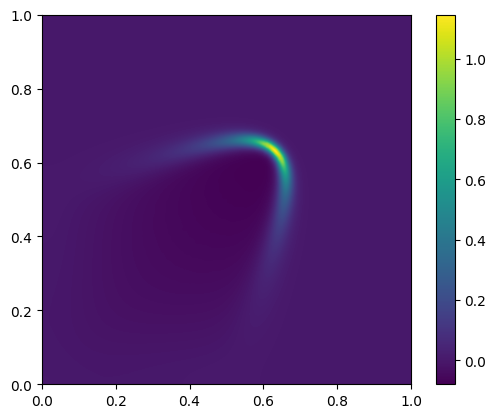

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
max(bandwidths_loc)

tensor(0.8932)

In [ ]:
min(bandwidths_loc)

tensor(0.0802)

In [ ]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()